# NLP model using K Nearest Neighbors Model 

## Data Aquisition

In [18]:
import pandas as pd

# Read training data
train_df = pd.read_csv('../data/projects/imdb_train.csv', header=0)

# Read test data
test_df = pd.read_csv('../data/projects/imdb_test.csv', header=0)

## Exploratory Data Aquisition

In [19]:
train_df.head(5)

,text,label
0,This movie makes me want to throw up every tim...,0
1,Listening to the director's commentary confirm...,0
2,One of the best Tarzan films is also one of it...,1
3,Valentine is now one of my favorite slasher fi...,1
4,No mention if Ann Rivers Siddons adapted the m...,0


In [20]:
test_df.head(5)

,text,label
0,What I hoped for (or even expected) was the we...,0
1,Garden State must rate amongst the most contri...,0
2,There is a lot wrong with this film. I will no...,1
3,"To qualify my use of ""realistic"" in the summar...",1
4,Dirty War is absolutely one of the best politi...,1


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [26]:
print("Number of observations in imdb database: {}".format(train_df.shape[0]))

Number of observations in imdb database: 25000


In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


No null values in the dataset.
Check the class distribution of 'label'.

In [29]:
train_df['label'].value_counts()

1    12500
0    12500
Name: label, dtype: int64

Class distribution of good and bad reviews are 50% each.

Though not much we can derive from a visualization, let's do it because I love colors.

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


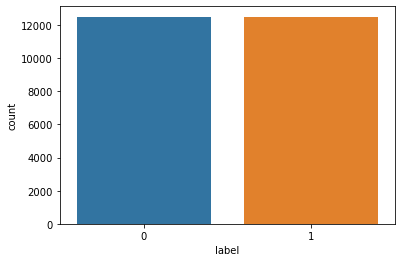

In [30]:
import seaborn as sns
sns.countplot(train_df['label']);

## Data Preparation

In [31]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# Following words can help the model to correctly test for postive and negative reviews
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# create a new stop_words list excluding the above list of words.
stop_words = [word for word in stop if word not in excluding]

# SnowballStemmer algorithm is also known as the Porter2 stemming algorithm. 
# It is almost universally accepted as better than the Porter stemmer, even being acknowledged as such by the individual who created the Porter stemmer. 
# SnowballStemmer is also more aggressive than the Porter stemmer.
snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df[["text"]],
                                                  train_df["label"],
                                                  test_size=0.20,
                                                  shuffle=True,
                                                  random_state=42)

In [57]:
train_text_list = process_text(X_train["text"].tolist())
val_text_list = process_text(X_val["text"].tolist())

## Data Preparation with pipeline for knn classifier

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Pipeline
# Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
# max_feature parameters may be modified
pipeline = Pipeline([('text_vect', CountVectorizer(binary=True,
                              max_features=15)),('knn', KNeighborsClassifier())  
                    ])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('text_vect', CountVectorizer(binary=True, max_features=15)),
                ('knn', KNeighborsClassifier())])

##Train the model

In [59]:
X_train = train_text_list
X_val = val_text_list

# Fit the Pipeline to training data
pipeline.fit(X_train, y_train.values)

Pipeline(steps=[('text_vect', CountVectorizer(binary=True, max_features=15)),
                ('knn', KNeighborsClassifier())])

## Test model parameters

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted pipeline to make predictions on the validation dataset
val_predictions = pipeline.predict(X_val)
print(confusion_matrix(y_val.values, val_predictions))
print(classification_report(y_val.values, val_predictions))
print("Accuracy (validation):", accuracy_score(y_val.values, val_predictions))

[[1330 1111]
 [1176 1383]]
              precision    recall  f1-score   support

           0       0.53      0.54      0.54      2441
           1       0.55      0.54      0.55      2559

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.54      0.54      0.54      5000

Accuracy (validation): 0.5426
